In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

In [69]:
# Load the dataset
data = pd.read_csv('review_data_clean.csv')
data.head()

,content,content_clean,score,label,content_length,content_clean_length
0,It's cool. pretty addicted to it try it! There...,cool pretti addict tri there mani thing,-1,Negative,15,7
1,fayjzugz GC hi hd for dust be so hd si,fayjzugz gc hi hd dust hd si,1,Positive,10,7
2,Nice game,nice game,6,Positive,2,2
3,Unlimited hero event continue. Bd hole do this...,unlimit hero event continu bd hole hero max,0,Neutral,10,8
4,So nice game,nice game,6,Positive,3,2


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               14567 non-null  object
 1   content_clean         14567 non-null  object
 2   score                 14567 non-null  int64 
 3   label                 14567 non-null  object
 4   content_length        14567 non-null  int64 
 5   content_clean_length  14567 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 683.0+ KB


In [71]:
# Menghapus feature
data.drop(['content', 'content_length', 'score','content_clean_length'], axis=1, inplace=True)
data.head()

,content_clean,label
0,cool pretti addict tri there mani thing,Negative
1,fayjzugz gc hi hd dust hd si,Positive
2,nice game,Positive
3,unlimit hero event continu bd hole hero max,Neutral
4,nice game,Positive


In [72]:
x = data['content_clean'].values
y = data['label'].values

In [73]:
# Split data menjadi test dan train
review_train, review_test, label_train, label_test = train_test_split(x, y, test_size=0.2)

In [74]:
# Tokenisasi
review_train_texts = [' '.join(review.split()) for review in review_train]
review_test_texts = [' '.join(review.split()) for review in review_test]

In [75]:
# Menggunakan CountVectorizer
count_vectorizer = CountVectorizer(max_features=200)
X_train_counts = count_vectorizer.fit_transform(review_train_texts)
X_test_counts = count_vectorizer.transform(review_test_texts)

# Menggunakan TF-IDF Transformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [76]:
# Membuat rata-rata vektor
def get_average_vector(tokens_list, vectorizer):
    vectors = vectorizer.transform([' '.join(tokens) for tokens in tokens_list])
    avg_vec = np.mean(vectors.toarray(), axis=0)
    return avg_vec

review_train_tokens = [tokens.split() for tokens in review_train_texts]
review_test_tokens = [tokens.split() for tokens in review_test_texts]

X_train_vectorized = get_average_vector(review_train_tokens, count_vectorizer)
X_test_vectorized = get_average_vector(review_test_tokens, count_vectorizer)

In [77]:
# Function untuk training model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    print(f"Model: {model_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, model.predict(X_test)))
    print("\n")

# Definisikan model machine learning yang akan digunakan
models = {
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

# Definisikan grid parameter untuk masing-masing model
param_grids = {
    "RandomForest": {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
    "SVM": {'C': [1, 10, 100], 'gamma': ['scale', 'auto']},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    "GradientBoosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
}

In [78]:
# Train dan evaluasi semua model dengan TF-IDF setelah tuning
print("=== Evaluasi dengan TF-IDF ===")
best_models_tfidf = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=1)
    grid_search.fit(X_train_tfidf, label_train)
    
    best_model = grid_search.best_estimator_
    best_models_tfidf[model_name] = best_model
    
    train_and_evaluate(best_model, X_train_tfidf, label_train, X_test_tfidf, label_test, model_name)
    print(f"Best parameters: {grid_search.best_params_}")
    print("\n")

=== Evaluasi dengan TF-IDF ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: RandomForest
Train Accuracy: 0.9825795932377929
Test Accuracy: 0.9547014413177762
Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.62      0.75       197
     Neutral       0.92      0.96      0.94       678
    Positive       0.97      0.98      0.98      2039

    accuracy                           0.95      2914
   macro avg       0.94      0.86      0.89      2914
weighted avg       0.95      0.95      0.95      2914



Best parameters: {'max_depth': None, 'n_estimators': 100}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model: SVM
Train Accuracy: 0.9485969278297434
Test Accuracy: 0.955044612216884
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.66      0.75       197
     Neutral       0.91      0.96      0.93       678
    Positive       0.98      

In [79]:
# Train dan evaluasi semua model dengan CountVectorizer setelah tuning
print("=== Evaluasi dengan CountVectorizer ===")
best_models_counts = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=1)
    grid_search.fit(X_train_counts, label_train)
    
    best_model = grid_search.best_estimator_
    best_models_counts[model_name] = best_model
    
    train_and_evaluate(best_model, X_train_counts, label_train, X_test_counts, label_test, model_name)
    print(f"Best parameters: {grid_search.best_params_}")
    print("\n")

=== Evaluasi dengan CountVectorizer ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: RandomForest
Train Accuracy: 0.9828370376727024
Test Accuracy: 0.9509265614275909
Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.61      0.72       197
     Neutral       0.91      0.96      0.93       678
    Positive       0.97      0.98      0.98      2039

    accuracy                           0.95      2914
   macro avg       0.92      0.85      0.88      2914
weighted avg       0.95      0.95      0.95      2914



Best parameters: {'max_depth': None, 'n_estimators': 300}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model: SVM
Train Accuracy: 0.9600102977773963
Test Accuracy: 0.9601921757035004
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.70      0.78       197
     Neutral       0.91      0.97      0.94       678
    Positive       

In [89]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000
embedding_dim = 16
max_len = 200

# Tokenize text data
tokenizer = Tokenizer(num_words=200, oov_token='<OOV>')
tokenizer.fit_on_texts(review_train_texts)

X_train_seq = tokenizer.texts_to_sequences(review_train_texts)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')

X_test_seq = tokenizer.texts_to_sequences(review_test_texts)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

label_encoder = LabelEncoder()
label_train_encoded = label_encoder.fit_transform(label_train)
label_test_encoded = label_encoder.transform(label_test)

In [90]:
# Define model architecture
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(GRU(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 units for 5 classes
])

In [91]:
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [92]:
class EarlyStoppingWithWarning(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"\nTraining stopped early at epoch {self.stopped_epoch + 1}.")
        else:
            print("\nTraining completed without early stopping.")

In [93]:
# Define callbacks
early_stopping = EarlyStoppingWithWarning(monitor='val_loss', patience=3, restore_best_weights=True)

In [94]:
# Train LSTM model
history_nn = model_lstm.fit(X_train_pad, label_train_encoded,
                            epochs=20, batch_size=32,
                            validation_data=(X_test_pad, label_test_encoded),
                            callbacks=[early_stopping])

Epoch 1/20
365/365 [==============================] - 293s 750ms/step - loss: 0.4591 - accuracy: 0.8297 - val_loss: 0.2340 - val_accuracy: 0.9159
Epoch 2/20
365/365 [==============================] - 270s 739ms/step - loss: 0.2234 - accuracy: 0.9295 - val_loss: 0.1654 - val_accuracy: 0.9533
Epoch 3/20
365/365 [==============================] - 270s 741ms/step - loss: 0.1924 - accuracy: 0.9438 - val_loss: 0.1533 - val_accuracy: 0.9537
Epoch 4/20
365/365 [==============================] - 270s 739ms/step - loss: 0.1791 - accuracy: 0.9466 - val_loss: 0.1617 - val_accuracy: 0.9530
Epoch 5/20
365/365 [==============================] - 297s 813ms/step - loss: 0.1880 - accuracy: 0.9420 - val_loss: 0.1684 - val_accuracy: 0.9465
Epoch 6/20
365/365 [==============================] - 286s 784ms/step - loss: 0.1777 - accuracy: 0.9466 - val_loss: 0.1646 - val_accuracy: 0.9499

Training stopped early at epoch 6.


In [95]:
# Train GRU model
history_gru = model_gru.fit(X_train_pad, label_train_encoded,
                            epochs=20, batch_size=32,
                            validation_data=(X_test_pad, label_test_encoded),
                            callbacks=[early_stopping])

Epoch 1/20
365/365 [==============================] - 105s 263ms/step - loss: 0.4917 - accuracy: 0.8404 - val_loss: 0.2074 - val_accuracy: 0.9324
Epoch 2/20
365/365 [==============================] - 64s 176ms/step - loss: 0.2115 - accuracy: 0.9383 - val_loss: 0.1624 - val_accuracy: 0.9506
Epoch 3/20
365/365 [==============================] - 64s 176ms/step - loss: 0.1874 - accuracy: 0.9456 - val_loss: 0.1643 - val_accuracy: 0.9533
Epoch 4/20
365/365 [==============================] - 62s 170ms/step - loss: 0.1780 - accuracy: 0.9465 - val_loss: 0.1591 - val_accuracy: 0.9550
Epoch 5/20
365/365 [==============================] - 64s 174ms/step - loss: 0.1752 - accuracy: 0.9490 - val_loss: 0.1564 - val_accuracy: 0.9533
Epoch 6/20
365/365 [==============================] - 64s 177ms/step - loss: 0.1706 - accuracy: 0.9499 - val_loss: 0.1562 - val_accuracy: 0.9526
Epoch 7/20
365/365 [==============================] - 66s 181ms/step - loss: 0.1693 - accuracy: 0.9487 - val_loss: 0.1526 - val_a

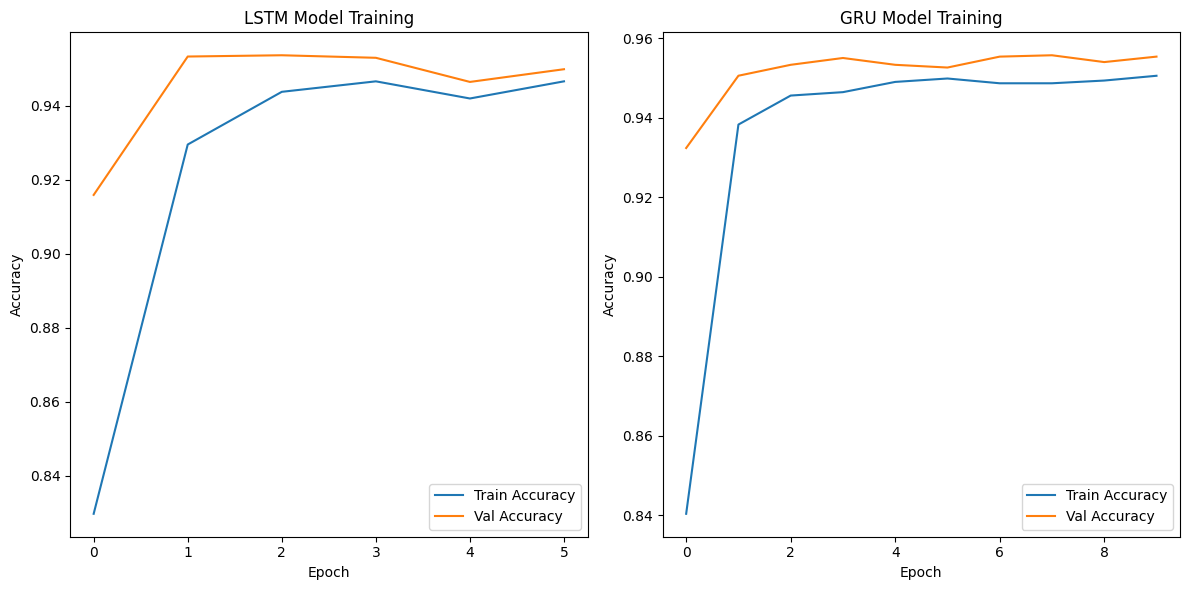

In [96]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'], label='Train Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Model Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()